# To run this, you need to run (or have run) the following in docker:
```
pip install textblob
pip install nltk
pip install twitterscraper
```

In [1]:
from twitterscraper import query_tweets
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix
import seaborn as sns
import hypertools as hyp
import numpy as np
from textblob import TextBlob as tb
import nltk
import datetime as dt
nltk.download('brown')
nltk.download('punkt')
%matplotlib inline

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Exploring twitter data

Scrape twitter for a keyword, fit topic models, do sentiment analyses on the tweets, and make a plot

In [18]:
#scrape twitter for most recent tweets on the minnesota lynx...this will take a while
n_tweets = 300
tweets = []
for tweet in query_tweets("minnesota lynx", n_tweets)[:n_tweets]:
    tweets.append(tweet)

In [19]:
tweets[0].timestamp

datetime.datetime(2017, 10, 8, 1, 8, 42)

In [20]:
#get the tweet text
tweet_text = list(map(lambda x: x.text, tweets))

In [21]:
tweets[0].user

'leftyRaff'

In [22]:
#convert the data to a useable format
n_features = 500
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words='english')
tf = tf_vectorizer.fit_transform(tweet_text)
tf_feature_names = tf_vectorizer.get_feature_names()

In [23]:
#fit a topic model to the tweets
n_topics = 10
lda = LDA(n_topics=n_topics, max_iter=5, learning_method='online', learning_offset=50., random_state=0).fit(tf)
tweet_topics = lda.fit(tf)

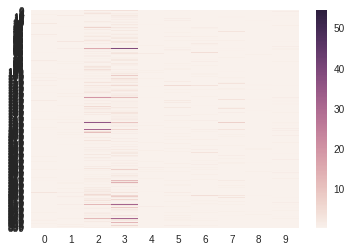

In [24]:
#topic vectors for each tweet
sns.heatmap(tweet_topics.components_.T)

In [25]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print('Topic ' + str(topic_idx) + ': ', end='')
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [26]:
display_topics(lda, tf_feature_names, 5)

Topic 0: team ass ago yrs championship
Topic 1: minnesotalynx know champions 4x wanna
Topic 2: lynx minnesota http com timberwolves
Topic 3: minnesotalynx com twitter wnba status
Topic 4: teams coverage say ve talking
Topic 5: great thanks ladies job julianjappert
Topic 6: congratulations thank great year plenette
Topic 7: lynx https prescient info google
Topic 8: news god dynasty crowd nope
Topic 9: la_sparks minnesotalynx http wnbafinals series


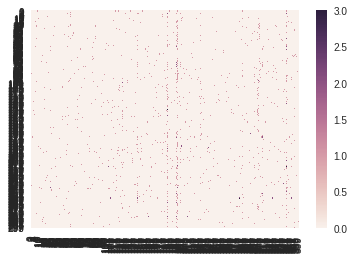

In [27]:
sns.heatmap(tf.todense())

In [28]:
blob = tb(tweet_text[0])

In [29]:
def tweet_sentiment(tweet):
    b = tb(tweet)
    return np.sum(np.array(list(map(lambda x: x.sentiment.polarity, b.sentences))))

In [30]:
sentiments = list(map(tweet_sentiment, tweet_text))

In [31]:
#happiest tweet
tweet_text[np.where(sentiments == np.max(sentiments))[0][0]]

'\xa0to see the AWESOME @WNBA 4X Champs @minnesotalynx on @TheEllenShow!  Amazing athletes! Extraordinary women! Hella funny too! #LynxOnEllenhttps://twitter.com/minnesotalynx/status/916389977235189760\xa0…'

In [32]:
#saddest tweet
tweet_text[np.where(sentiments == np.min(sentiments))[0][0]]

"I'm disgusted nothing what so ever in the Mpls.Tribune on Sunday. I know they played Wed.,although not one peep!"

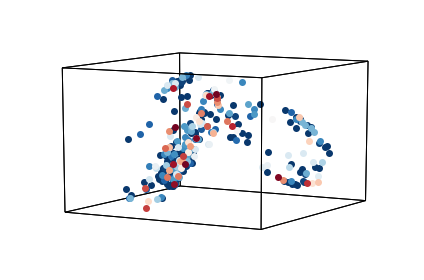

In [34]:
#make a hypertools plot of the tweets, colored by sentiment
hyp.plot(tweet_topics.components_.T, 'o', group=sentiments, palette='RdBu_r', model='SpectralEmbedding');

# Defining some useful Twitter-related functions

In [35]:
# function for scraping twitter for one or more keywords and returning a dictionary with:
# - tweets: the tweet text (list of length n_tweets)
# - topicvecs: the tweet topic vectors (numpy array with n_tweets rows and n_topics columns)
# - topwords: the top n words from each topic (list of length n_topics, where each element is a list of n_words)
# - sentiments: the sentiment valence of each tweet (numpy array of length n_tweets)

def twitter_magic(keywords, n_tweets=100, n_topics=10, n_words=5, model=None):
    #if keywords is a list, combine all keywords into a single string, where each word is separated by " OR "
    if type(keywords) == list:
        keywords = ' OR '.join(keywords)
    
    #get the tweets
    tweets = []
    for tweet in query_tweets(keywords, n_tweets)[:n_tweets]:
        tweets.append(tweet)
    
    #get the tweet text
    tweet_text = list(map(lambda x: x.text, tweets))
    
    #get the twitter users
    tweet_users = list(map(lambda x: x.user, tweets))
    
    #fit a topic model to the tweet text    
    n_features = 1000
    tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words='english')
    tf = tf_vectorizer.fit_transform(tweet_text)    
    vocab = tf_vectorizer.get_feature_names()
    
    if model == None:
        lda = LDA(n_topics=n_topics, max_iter=5, learning_method='online', learning_offset=50., random_state=0).fit(tf)
    else:
        lda = model            
    tweet_topics = lda.fit(tf)
    
    def get_top_words(model, vocab, n_words):
        top_words = []
        for topic_idx, topic in enumerate(model.components_):       
            next = topic.argsort()[:-n_words - 1:-1]
            top_words.append(list(map(lambda x: vocab[x], next)))
        return top_words
    
    def tweet_sentiment(tweet):
        b = tb(tweet)
        return np.sum(np.array(list(map(lambda x: x.sentiment.polarity, b.sentences))))
    
    return{'tweets': tweet_text,
           'users': tweet_users,
           'topicvecs': lda.components_.T,
           'topwords': get_top_words(lda, vocab, n_words),
           'sentiments': np.array(list(map(tweet_sentiment, tweet_text))),
           'model': lda}

In [54]:
n = 300 #number of tweets to download for each lynx player

moore = twitter_magic(['lynx AND moore', 'moore AND wnba'], n_tweets=n)

#now fit whalen tweets using the topic model from trump_election_tweets (otherwise the topic vectors will be different)
whalen = twitter_magic(['lynx AND whalen', 'whalen AND wnba'], n_tweets=n, model=moore['model'])

#now fit fowles tweets (using the same topic model)
fowles = twitter_magic(['lynx AND fowles', 'fowles AND wnba'], n_tweets=n, model=moore['model'])

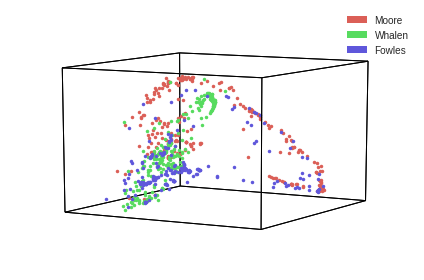

In [55]:
#plot the minnesota lynx player tweets
hyp.plot([moore['topicvecs'], whalen['topicvecs'], fowles['topicvecs']],
         '.', model='SpectralEmbedding', legend=['Moore', 'Whalen', 'Fowles']);

In [41]:
whalen['topicvecs'][0]

array([ 0.53868023,  0.47861072,  0.52417766,  0.54301285,  0.44360493,
        0.47334275,  0.50536938,  0.50511871,  1.32780155,  0.46950172])

In [42]:
whalen_tweets = list(map(lambda x: x == 'wnba', whalen['users']))

In [43]:
whalen_tweets

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,


In [44]:
whalen['topwords']

[['title', 'fourth', 'https', 'dynasty', 'ly'],
 ['league', 'ago', 'season', 'best', 'com'],
 ['sparks', 'win', 'championship', 'http', 'ihe'],
 ['sparks', 'warriors', 'cavaliers', 'lynxprowlers', 'huge'],
 ['http', 'sparks', '2017', 'ift', 'tt'],
 ['la', 'championship', 'won', 'blavity', 'minnesota'],
 ['won', 'mn', '11', 'son', 'team'],
 ['minnesota', 'effect', 'com', 'http', 'twitter'],
 ['com', 'http', 'minnesota', 'twitter', '2017'],
 ['says', 'assistant', 'patterson', 'http', 'shelley']]

In [45]:
whalen['tweets'][0]

"The Sparks-Lynx can be the WNBA's Warriors-Cavaliers http://www.oursportshow.com/sparks-lynx-rivalry-warriors-cavaliers/\xa0… #WNBA #WatchMeWork"

In [48]:
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
correlations = 1 - squareform(pdist(whalen['topicvecs']))

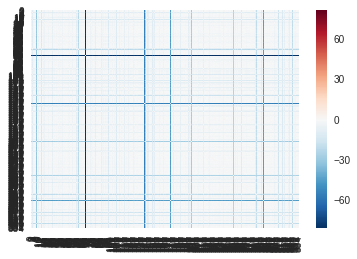

In [49]:
sns.heatmap(correlations)

In [50]:
#get the happiest and saddest tweets from each player
def get_happiest_tweets(results):
    return results['tweets'][np.where(results['sentiments'] == np.max(results['sentiments']))[0][0]]

def get_saddest_tweets(results):
    return results['tweets'][np.where(results['sentiments'] == np.min(results['sentiments']))[0][0]]

candidates = ['moore', 'whalen', 'fowles']

print('HAPPIEST TWEETS:')
for c in candidates:
    print(c.upper() + '-CONTAINING: ' + get_happiest_tweets(eval(c)) + '\n')
    
print('\n\nSADDEST TWEETS:')
for c in candidates:
    print(c.upper() + '-CONTAINING: ' + get_saddest_tweets(eval(c)) + '\n')

HAPPIEST TWEETS:
MOORE-CONTAINING: pic.twitter.com/o4knKXWGrX MN Lynx Best in the Midwest . Let's just call y'all TEAM  AWESOME!!!

WHALEN-CONTAINING: I still think they were the best team I’ve watched in the WNBA. No disrespect to the awesome Lynx and Sparks teams. #wnbafan

FOWLES-CONTAINING: I still think they were the best team I’ve watched in the WNBA. No disrespect to the awesome Lynx and Sparks teams. #wnbafan



SADDEST TWEETS:
MOORE-CONTAINING: Maya Moore ices Game 5 with cold-blooded runner to help seal Lynx's dynasty . @MooreMaya is so cold. #Ms.MJ23http://bleacherreport.com/post/wnba/73cb01cd-e6a9-483b-90c8-bbb09510b206 …

WHALEN-CONTAINING: @LeifSkodnick Very disappointed. Ur paper had NO COVERAGE of a dynasty. Minnesota Lynx 4th WNBA championship since 2011. WNBA needs respect

FOWLES-CONTAINING: @LeifSkodnick Very disappointed. Ur paper had NO COVERAGE of a dynasty. Minnesota Lynx 4th WNBA championship since 2011. WNBA needs respect

